# **Lab 9.1 Generative Adversarial Network**
**NOTE :** Use the dataset from lab5.

In [205]:
import torch
from torch import nn
from tqdm import tqdm
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os
import random

## Architecture
Complete the GAN architecture that generates RGB images of size 128x128.

In [206]:
# import tarfile

# # Specify the file name
# file_name = 'data.tar.gz'

# # Open the tar.gz file
# with tarfile.open(file_name, 'r:gz') as tar:
#     # Extract all contents into the current directory
#     tar.extractall()

# print("Extraction complete!")

In [207]:
### START CODE HERE ###
class Generator(nn.Module):
    def __init__(self, z_dim=256, im_ch=3, hidden_dim=1024):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.conv_block(z_dim, hidden_dim, kernel_size=4, stride=1), 
            self.conv_block(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1), 
            self.conv_block(hidden_dim // 2, hidden_dim // 4, kernel_size=4, stride=2, padding=1), 
            self.conv_block(hidden_dim // 4, hidden_dim // 8, kernel_size=4, stride=2, padding=1), 
            self.conv_block(hidden_dim // 8, hidden_dim // 16, kernel_size=4, stride=2, padding=1), 
            self.conv_block(hidden_dim // 16, im_ch, kernel_size=4, stride=2, padding=1, final_layer=True),
        )

    def conv_block(self, in_ch, out_ch, kernel_size=4, stride=1, padding=0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_ch),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh()  # For generating images, often use Tanh activation
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
### END CODE HERE ###

In [208]:
### START CODE HERE ###
class Discriminator(nn.Module):
    def __init__(self, im_ch=3, hidden_dim=32):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            self.conv_block(im_ch, hidden_dim, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim * 8, 1, final_layer=True),
        )

    def conv_block(self, in_ch, out_ch, kernel_size=4, stride=1, padding=0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Sigmoid()
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)
### END CODE HERE ###

Complete the function below. The `get_noise` function generates a random noise tensor that is typically used as input to a Generator
- `n_sample`: The number of noise samples to generate.

- `z_dim`: The dimensionality of each noise vector.

- `device`: The device on which the tensor will be allocated. By default, it is set to 'cuda'

In [209]:
### START CODE HERE ###
def get_noise(n_sample, z_dim, device='cuda'):
    # Check if CUDA is available, otherwise use CPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Generate random noise tensor from a normal distribution
    noise = torch.randn(n_sample, z_dim, device=device)
    return noise
### END CODE HERE ###

In [210]:
n_sample = 25
z_dim = 100
noise = get_noise(n_sample, z_dim)
assert noise.shape == (n_sample, z_dim), f"Expected shape {(n_sample, z_dim)}, but got {noise.shape}"

noise_cpu = get_noise(n_sample, z_dim, device='cpu')
assert noise_cpu.device.type == 'cpu', f"Expected tensor to be on 'cpu', but got {noise_cpu.device.type}"
assert noise.dtype == torch.float32, f"Expected dtype to be torch.float32, but got {noise.dtype}"

## Preparation
Prepare all training components such as the dataset, batch size, optimizer, and model, etc. No need to perform a train-test split.

In [211]:
# Create a simple DataLoader from the image paths
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [212]:
### START CODE HERE ###
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load dataset
relative_dir = "data/img_align_celeba"
data_dir = os.path.abspath(relative_dir)
# print(data_dir)
image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith(".jpg")]

#---------------------
# sample_image_paths = random.sample(image_paths, 10)
# # สร้าง dataset และ dataloader
# dataset = ImageDataset(sample_image_paths, transform=transform)
# batch_size = 2 
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#---------------------

# Instantiate the dataset
dataset = ImageDataset(image_paths=image_paths, transform=transform)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define model dimensions
z_dim = 256
im_ch = 3
hidden_dim = 1024

# Instantiate models
generator = Generator(z_dim=z_dim, im_ch=im_ch, hidden_dim=hidden_dim)
discriminator = Discriminator(im_ch=im_ch, hidden_dim=32)

# Check device availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator.to(device)
discriminator.to(device)
### END CODE HERE ###

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequen

Display first batch of dataset.

In [213]:
def display_images(images, n_cols=4, n_rows=4):
    """
    Display a grid of images.
    
    Parameters:
    - images: NumPy array of shape (N, C, H, W) where N is the number of images,
      C is the number of channels, H is height, and W is width.
    - n_cols: Number of columns in the grid.
    - n_rows: Number of rows in the grid.
    """
    # Ensure images are in the shape (N, H, W, C)
    if images.ndim == 4 and images.shape[1] in [1, 3]:  # (N, C, H, W)
        images = np.transpose(images, (0, 2, 3, 1))  # Change to (N, H, W, C)
        

    plt.figure(figsize=(n_cols * 2, n_rows * 2))  # Adjust size based on grid dimensions
    for i in range(min(n_cols * n_rows, len(images))):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(images[i])
        ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

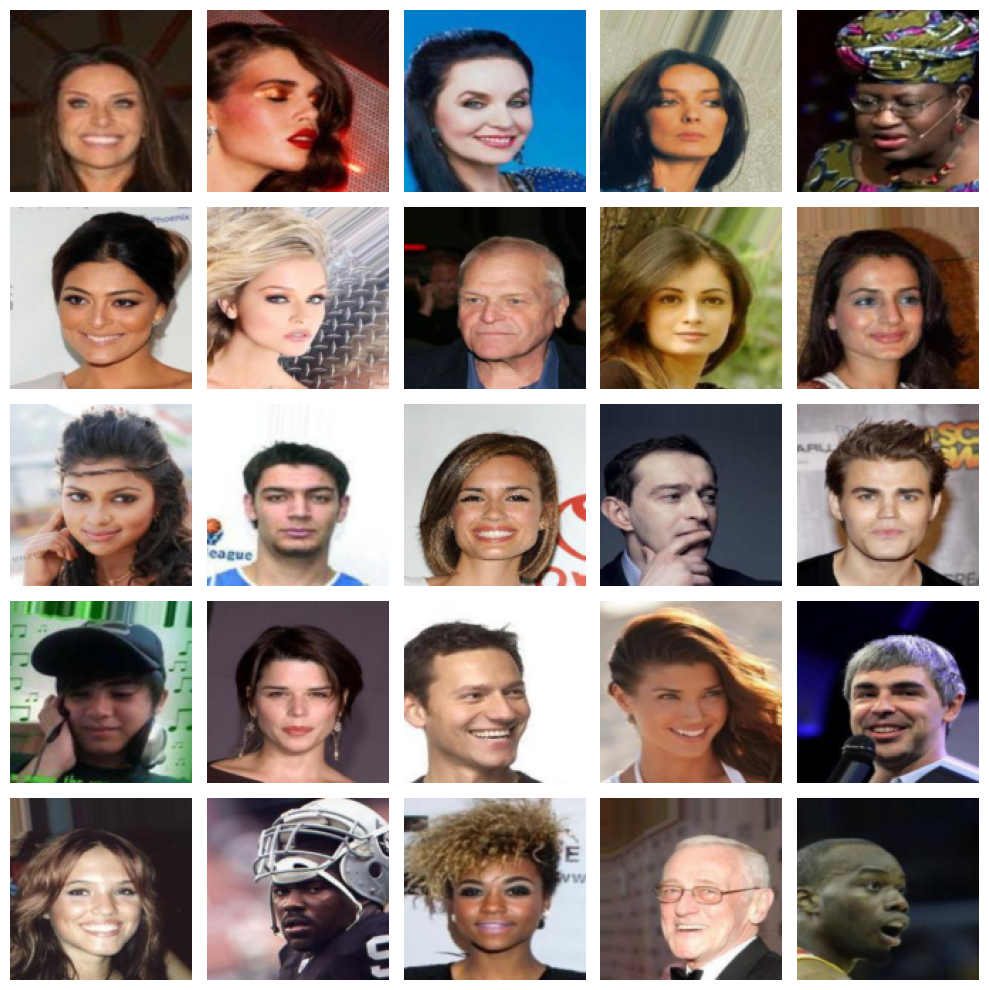

In [214]:
### START CODE HERE ###

# Display first batch of dataset
data_iter = iter(dataloader)
images = next(data_iter)

# Convert tensor to numpy for plotting
images = images * 0.5 + 0.5  # Denormalize images to [0, 1]
images = images.numpy()

display_images(images, n_cols=5, n_rows=5)
### END CODE HERE ###

Use `get_noise` to generate noise with 25 samples, and then use the generator to generate images with that noise.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/1.png?raw=true)


</details>

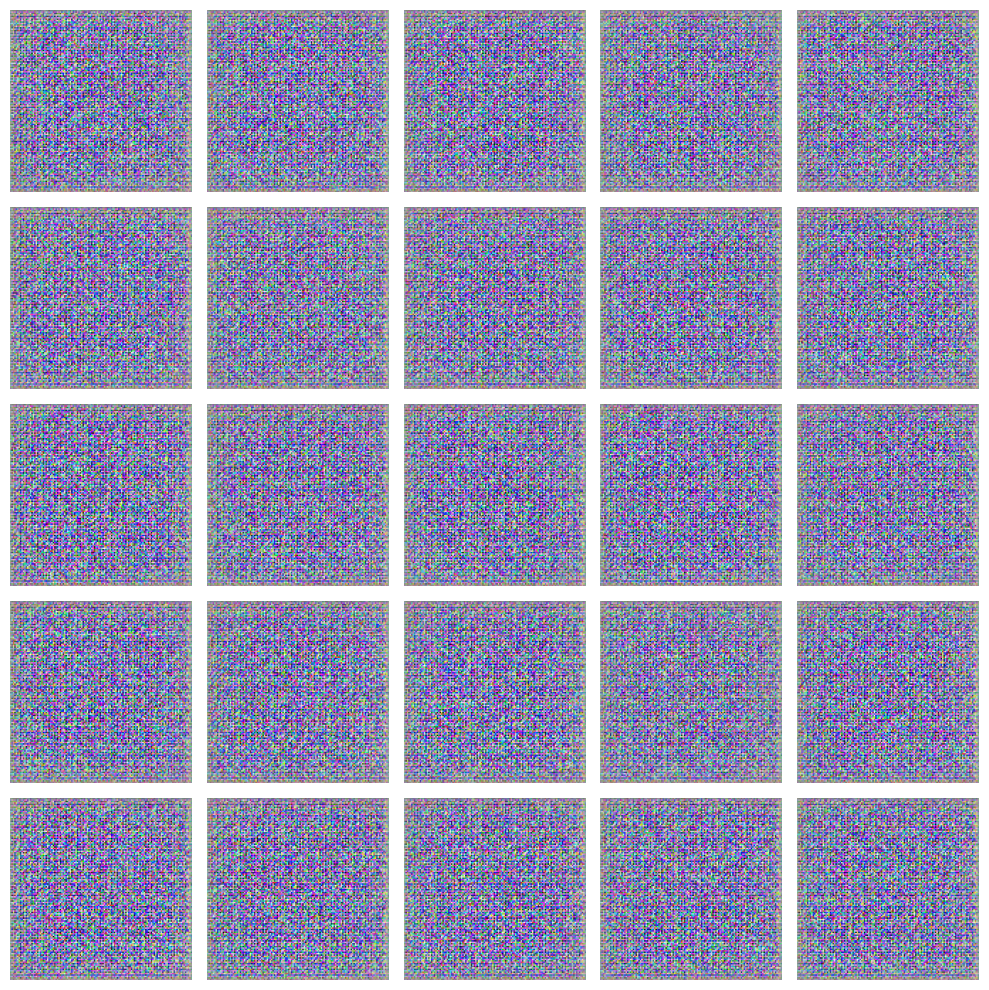

In [215]:
### START CODE HERE ###
# Generate noise and create images
n_samples = 25
noise = get_noise(n_samples, z_dim, device)

# Generate images using the generator
with torch.no_grad():  # Disable gradient calculation for inference
    generated_images = generator(noise)

# Convert tensor to numpy for plotting
generated_images = generated_images * 0.5 + 0.5  # Denormalize images to [0, 1]
generated_images = generated_images.cpu().numpy()  # Move to CPU and convert to numpy

display_images(generated_images, n_cols=5, n_rows=5)
### END CODE HERE ###

Complete the training function that trains and logs the average loss for both the generator and discriminator, and generates sample images at each epoch (using the same input vector as the previous part) to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).
<details>
<summary>
<font size="3" color="orange">
<b>Expected output in tensorboard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/2.png?raw=true)


</details>


In [216]:
# from tqdm import tqdm

# def train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
#     # Set models to training mode
#     generator.train()
#     discriminator.train()

#     for epoch in range(epochs):
#         gen_loss_total = 0.0
#         disc_loss_total = 0.0
        
#         # Wrap the dataloader with tqdm for progress visualization
#         with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
#             for batch in dataloader:
#                 batch = batch.to(device)  # Move batch to the appropriate device
#                 batch_size = batch.size(0)

#                 # -----------------
#                 # Train Discriminator
#                 # -----------------
#                 disc_opt.zero_grad()

#                 # Generate fake images
#                 noise = get_noise(batch_size, z_dim, device)
#                 fake_images = generator(noise)

#                 # Compute discriminator predictions with sigmoid activation
#                 real_preds = torch.sigmoid(discriminator(batch))
#                 fake_preds = torch.sigmoid(discriminator(fake_images.detach()))

#                 # Compute discriminator loss
#                 disc_loss_real = criterion(real_preds, torch.ones_like(real_preds, device=device))
#                 disc_loss_fake = criterion(fake_preds, torch.zeros_like(fake_preds, device=device))
#                 disc_loss = disc_loss_real + disc_loss_fake

#                 disc_loss.backward()
#                 disc_opt.step()

#                 disc_loss_total += disc_loss.item()

#                 # -----------------
#                 # Train Generator
#                 # -----------------
#                 gen_opt.zero_grad()

#                 # Compute generator loss
#                 fake_preds = torch.sigmoid(discriminator(fake_images))  # Use sigmoid for generator loss
#                 gen_loss = criterion(fake_preds, torch.ones_like(fake_preds, device=device))

#                 gen_loss.backward()
#                 gen_opt.step()

#                 gen_loss_total += gen_loss.item()

#                 # Update progress bar
#                 pbar.set_postfix(gen_loss=gen_loss.item(), disc_loss=disc_loss.item())
#                 pbar.update(1)  # Increment progress bar

#         # Average losses for this epoch
#         avg_gen_loss = gen_loss_total / len(dataloader)
#         avg_disc_loss = disc_loss_total / len(dataloader)

#         # Log losses to TensorBoard
#         if writer:
#             writer.add_scalar('Loss/Generator', avg_gen_loss, epoch)
#             writer.add_scalar('Loss/Discriminator', avg_disc_loss, epoch)

#             # Generate and log sample images
#             with torch.no_grad():
#                 sample_images = generator(test_noise)
#                 sample_images = sample_images * 0.5 + 0.5  # Denormalize
#                 grid = torchvision.utils.make_grid(sample_images, nrow=5)  # Create a grid of images
#                 writer.add_image('Generated Images', grid, epoch)

#         print(f'Epoch [{epoch + 1}/{epochs}]\nGen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')

#         # Save checkpoint if specified
#         if checkpoint_path:
#             torch.save({
#                 'epoch': epoch,
#                 'generator_state_dict': generator.state_dict(),
#                 'discriminator_state_dict': discriminator.state_dict(),
#                 'gen_opt_state_dict': gen_opt.state_dict(),
#                 'disc_opt_state_dict': disc_opt.state_dict(),
#             }, checkpoint_path)


In [217]:
def plot_losses_and_images(generator_losses, discriminator_losses, test_gen_img):
    plt.clf()  # Clear the current figure

    n_images = test_gen_img.size(0)  # Number of generated images
    grid_size = int(n_images ** 0.5)  # Calculate grid size for plotting

    # Create a figure for losses
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Plot generator losses
    if generator_losses:
        ax[0].plot(generator_losses, label='Generator Loss', color='blue')
        ax[0].set_title('Generator Loss Over Time')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()
    else:
        print("No generator loss data to plot.")

    # Plot discriminator losses
    if discriminator_losses:
        ax[1].plot(discriminator_losses, label='Discriminator Loss', color='red')
        ax[1].set_title('Discriminator Loss Over Time')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Loss')
        ax[1].legend()
    else:
        print("No discriminator loss data to plot.")

    plt.tight_layout()  # Adjust layout

    # Create a figure for generated images
    plt.figure(figsize=(12, 12))
    for i in range(n_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.imshow(test_gen_img[i].permute(1, 2, 0).clamp(0, 1))  # Change from (C, H, W) to (H, W, C) and clamp values
        ax.axis('off')  # Turn off axis

    plt.suptitle('Generated Images')
    plt.show()


In [219]:
def train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    generator.train()
    discriminator.train()
    
    generator_losses = []
    discriminator_losses = []
    
    for epoch in range(epochs):
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        cur_step = 0
        
        # Use tqdm for a progress bar
        train_bar = tqdm(dataloader, total=len(dataloader))

        for real in train_bar:
            real = real.to(device)  # Move to the correct device
            cur_batch_size = real.size(0)  # Get current batch size

            # Train discriminator
            disc_opt.zero_grad()

            # Generate fake images
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = generator(fake_noise)

            # Discriminator predictions
            disc_fake_pred = discriminator(fake.detach())
            disc_real_pred = discriminator(real)

            # Loss calculations
            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred, device=device))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred, device=device))

            # Total discriminator loss
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            mean_discriminator_loss += disc_loss.item()
            disc_loss.backward()
            disc_opt.step()

            # Train generator
            gen_opt.zero_grad()

            # Generate fake images again
            fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
            fake_2 = generator(fake_noise_2)
            disc_fake_pred = discriminator(fake_2)

            # Generator loss
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred, device=device))
            gen_loss.backward()
            gen_opt.step()

            mean_generator_loss += gen_loss.item()
            cur_step += 1

            # Update progress bar
            train_bar.set_postfix(DiscLoss=disc_loss.item(), GenLoss=gen_loss.item())

        # Average losses for this epoch
        mean_generator_loss /= len(dataloader)
        mean_discriminator_loss /= len(dataloader)
        
        generator_losses.append(mean_generator_loss)
        discriminator_losses.append(mean_discriminator_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Generator Loss: {mean_generator_loss:.4f}, Discriminator Loss: {mean_discriminator_loss:.4f}')

        # Generate test images for visualization
        with torch.no_grad():  # Disable gradient calculation for inference
            test_gen_img = generator(test_noise)
            plot_losses_and_images(generator_losses, discriminator_losses, test_gen_img)

        # Optionally save checkpoints
        if checkpoint_path:
            checkpoint = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_opt_state_dict': gen_opt.state_dict(),
                'disc_opt_state_dict': disc_opt.state_dict(),
            }
            torch.save(checkpoint, checkpoint_path)


100%|██████████| 469/469 [1:19:09<00:00, 10.13s/it, DiscLoss=0.148, GenLoss=2.16] 


Epoch [1/2], Generator Loss: 3.2611, Discriminator Loss: 0.2650


<Figure size 640x480 with 0 Axes>

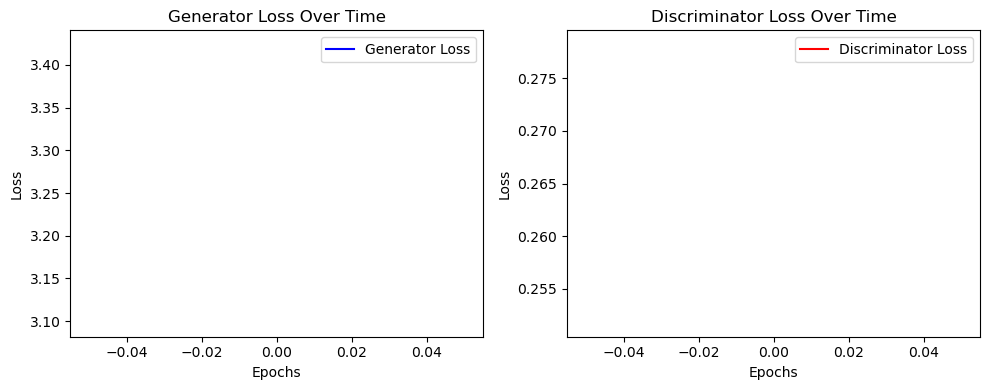

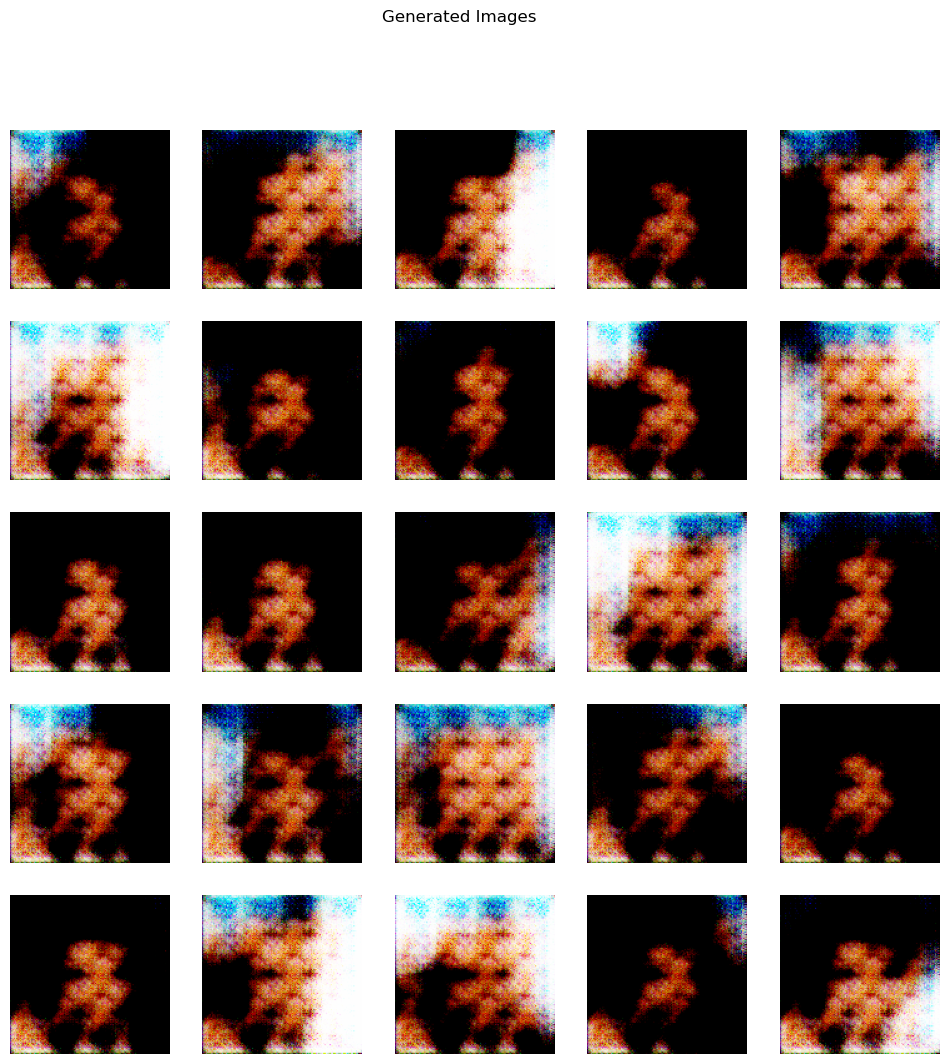

100%|██████████| 469/469 [1:13:48<00:00,  9.44s/it, DiscLoss=0.244, GenLoss=2.48] 


Epoch [2/2], Generator Loss: 2.3360, Discriminator Loss: 0.4350


<Figure size 640x480 with 0 Axes>

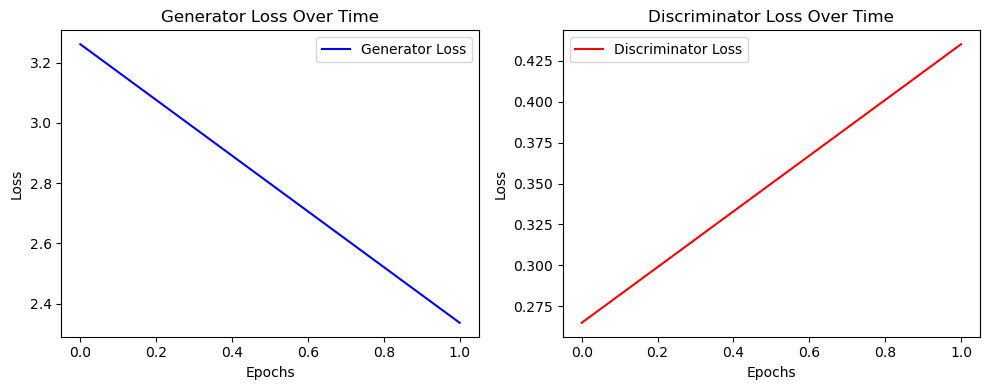

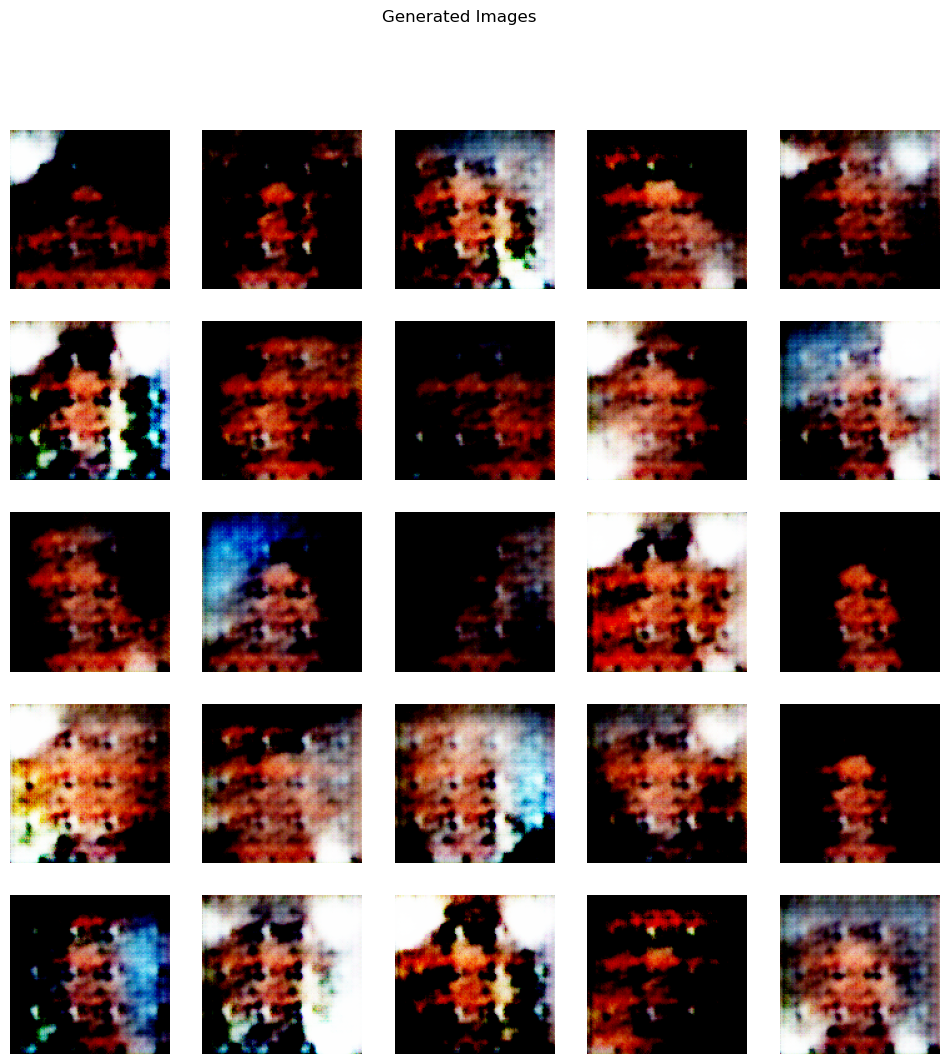

In [220]:
### START CODE HERE ###
# Define optimizers
lr = 0.0002
beta1 = 0.5

gen_opt = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
disc_opt = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Define loss function
criterion = torch.nn.BCELoss()

# Create a fixed noise vector for generating sample images
test_noise = get_noise(25, z_dim, device)

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='logs/gan_experiment')

# Specify checkpoint path
checkpoint_path = 'checkpoints/gan_checkpoint.pth'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)  # Create directories if they don't exist

num_epochs=2
# Call the training function
train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim, epochs=num_epochs, writer=writer, checkpoint_path=checkpoint_path, device=device)

# Close the TensorBoard writer
writer.close()
### END CODE HERE ###

Test Genereate the image.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/3.png?raw=true)


</details>

In [221]:
# Generate and display images
def generate_images(generator, num_images=25, z_dim=z_dim, device='cpu'):
    generator.eval()  # Set to evaluation mode
    with torch.no_grad():
        noise = get_noise(num_images, z_dim, device)
        generated_imgs = generator(noise).clamp(-1, 1)  # Clamp to [-1, 1]
        return (generated_imgs + 1) / 2  # Scale to [0, 1]

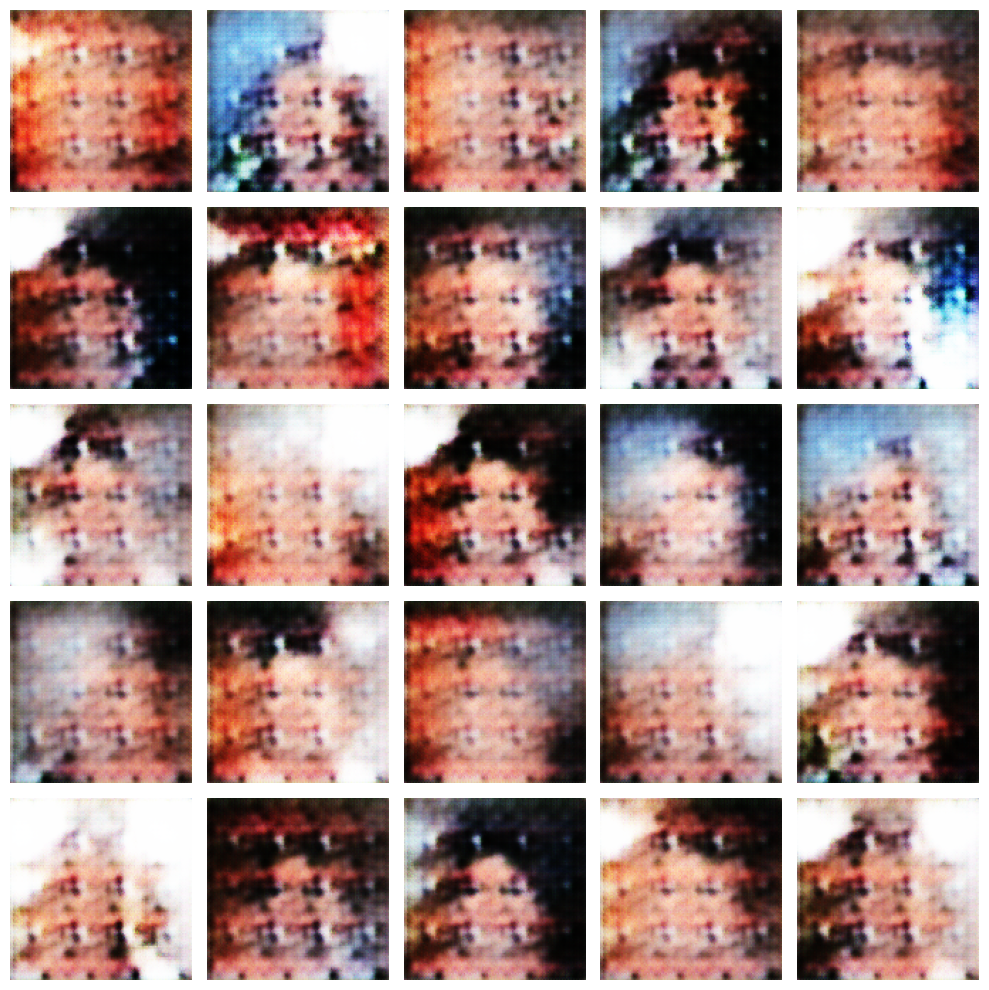

In [222]:
### START CODE HERE ###
# Generate and display images after training
generated_images = generate_images(generator, num_images=25, z_dim=z_dim, device=device)

display_images(generated_images, n_cols=5, n_rows=5)
### END CODE HERE ###

---

# Question
1. In the architecture of a discriminator, if the last layer is not a fully connected layer and the output is in a 3D tensor format rather than a 1D vector, how would you compute the Binary Cross-Entropy Loss (BCELoss) in this case?

2. If the architecture of the generator includes one or more hidden fully connected layers before the output layer, how would this affect the quality or characteristics of the generated output? 

3. When alternating between training the generator and the discriminator in a GAN, at which level should this switching occur to achieve optimal results—should it be done at the epoch level, the iteration level, or the batch level?

# Answers